In [43]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten, Add, AveragePooling2D, Input, ZeroPadding2D
from tensorflow.keras.layers import Activation, BatchNormalization, Add, Reshape, DepthwiseConv2D, GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
data_dir = '/Users/linhtuanpham/Downloads/lung_colon_image_set'

filepaths = []
labels = []


for root, dirs, files in os.walk(data_dir):
    for klass in dirs:
        if klass in ["lung_image_sets", "colon_image_sets"]:
            continue  # Skip the main classes, only consider subclasses
        classpath = os.path.join(root, klass)
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            filepaths.append(fpath)
            labels.append(klass)

Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
data_df = pd.concat([Fseries, Lseries], axis=1)
df = data_df.reset_index(drop=True)  # Make a combined dataframe

print(df['labels'].value_counts())

labels
lung_aca     5000
lung_n       5000
lung_scc     5000
colon_n      5000
colon_aca    5000
Name: count, dtype: int64


In [45]:
sample_size=5000
sample_list=[]
group=df.groupby('labels')
for label in df['labels'].unique():    
    label_group=group.get_group(label).sample(sample_size, replace=False, random_state=123, axis=0)    
    sample_list.append(label_group)
df=pd.concat(sample_list, axis=0).reset_index(drop=True)
print (len(df))

25000


In [47]:
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), ' test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  20000  test_df length:  2500   valid_df length:  2500


In [49]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
height=224
width=224
channels=3
batch_size=32
img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):
    return img/127.5-1  # scale pixel between -1 and +1
gen=ImageDataGenerator(preprocessing_function=scalar)
train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen=gen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
valid_gen=gen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
class_count=len(classes)

test batch size:  50   test steps:  50
Found 20000 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


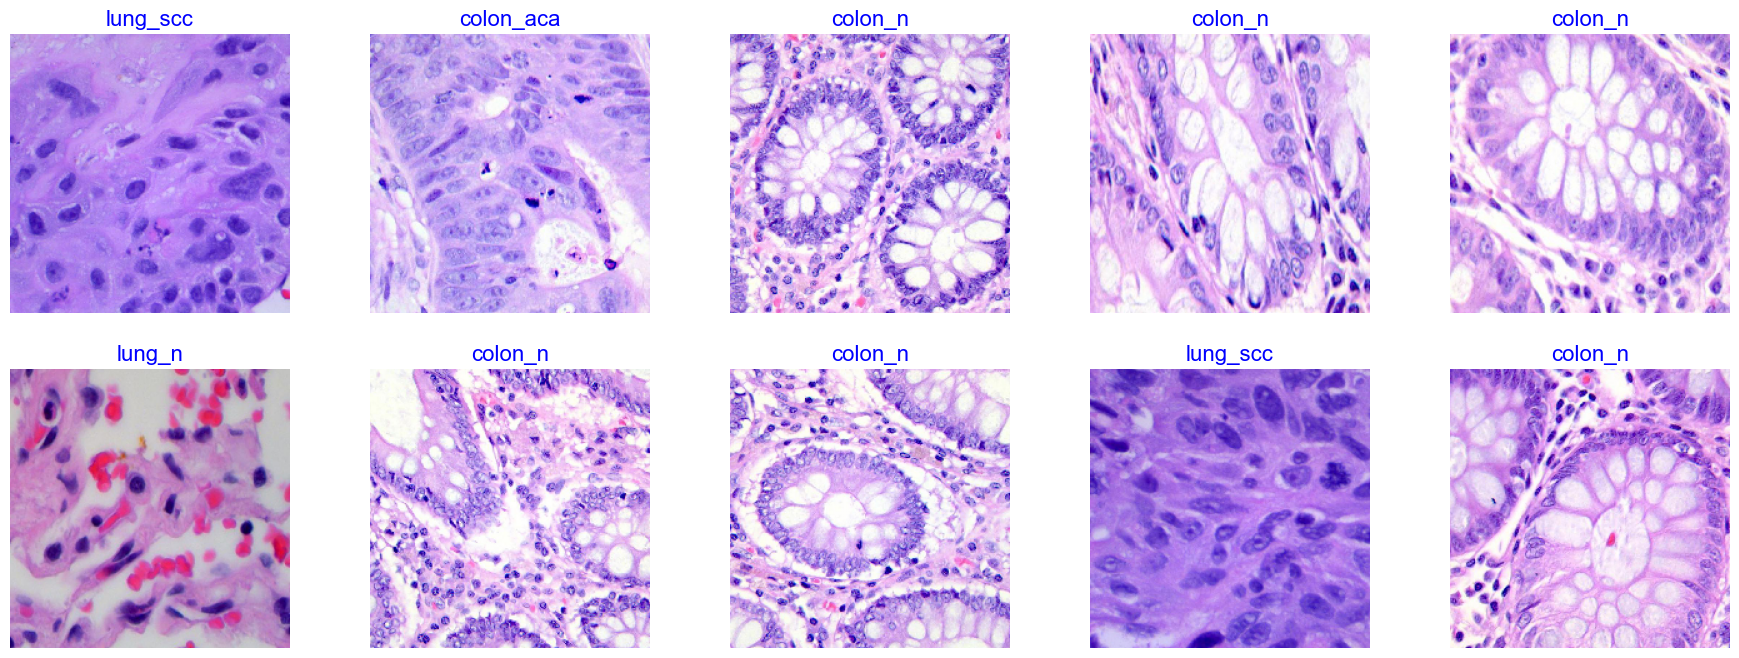

In [51]:
def show_image_samples(gen ):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<10:   #show maximum of 25 images
        r=length
    else:
        r=10
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=(images[i]+1 )/2 # scale images between 0 and 1 becaue pre-processor set them between -1 and +1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()
show_image_samples(train_gen)

In [53]:
IMG_SIZE=224
from tensorflow.keras.metrics import Recall, Precision, AUC, RootMeanSquaredError
from sklearn.metrics import f1_score
num_classes=len(classes)
print(num_classes)

5


In [55]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Concatenate

mobilenet = MobileNet(weights='imagenet', include_top=False)

for layer in mobilenet.layers:
    layer.trainable = False

input_layer = Input(shape=(224,224,3))

x1 = mobilenet(input_layer)
concatenated = Concatenate()([x1])

flat = Flatten()(concatenated)
dense = Dense(units=1024, activation='relu')(flat)
dense = Dense(512, activation='relu')(dense)
dense = Dense(units=256, activation='relu')(dense)
predictions = Dense(num_classes, activation='softmax')(dense)

model = Model(inputs=input_layer, outputs=predictions)

/var/folders/0w/n8j1dj1s13d5mf73xzjt1f980000gn/T/ipykernel_66328/2830154816.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNet(weights='imagenet', include_top=False)


In [57]:
x1

<KerasTensor shape=(None, 7, 7, 1024), dtype=float32, sparse=False, name=keras_tensor_704>

In [59]:
model.compile(Adam(learning_rate=.001), loss='categorical_crossentropy', 
              metrics=['accuracy', Precision(), Recall(), AUC(), 'mae', 'mse', RootMeanSquaredError()])
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concatenate_1 (Concatenate)     │ (None, 7, 7, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1024)           │    51,381,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,267,525 (210.83 MB)

 Trainable params: 52,038,661 (198.51 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [61]:
model_name='MobileNet'
from tensorflow.python.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor= 'val_loss', patience=5,mode = 'min' ,verbose=1)
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) 
    return

In [63]:
import tensorflow as tf
import numpy as np
import time
from tensorflow import keras

class LRA(keras.callbacks.Callback):
    reset = False
    count = 0
    stop_count = 0
    tepochs = 0
    best_weights = None
    
    def __init__(self, model, patience, stop_patience, threshold, factor, dwell, model_name, freeze, initial_epoch):
        super(LRA, self).__init__()
        self._model = model
        self.patience = patience
        self.stop_patience = stop_patience
        self.threshold = threshold
        self.factor = factor
        self.dwell = dwell
        self.lr = float(tf.keras.backend.get_value(model.optimizer.learning_rate))
        self.highest_tracc = 0.0
        self.lowest_vloss = np.inf
        self.initial_epoch = initial_epoch
        LRA.best_weights = model.get_weights()
        
        msgs = (f' Starting training using base model {model_name} with weights frozen to imagenet weights initializing LRA callback'
                if freeze else
                f' Starting training using base model {model_name} training all layers ')
        print_in_color(msgs, (244, 252, 3), (55,65,80))
    
    @property
    def model(self):
        return self._model
        
    @model.setter
    def model(self, value):
        self._model = value
        
    def on_epoch_begin(self, epoch, logs=None):
        self.now = time.time()
        
    def on_epoch_end(self, epoch, logs=None):
        later = time.time()
        duration = later - self.now
        
        if epoch == self.initial_epoch or LRA.reset:
            LRA.reset = False
            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}'.format(
                'Epoch', 'Loss', 'Acc', 'V_loss', 'V_acc', 'LR', 'Next LR'
            )
            print_in_color(msg, (244,252,3), (55,65,80))
        
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        current_lr = lr
        v_loss = logs.get('val_loss')
        acc = logs.get('accuracy')
        v_acc = logs.get('val_accuracy')
        loss = logs.get('loss')
        
        if acc < self.threshold:
            if acc > self.highest_tracc:
                self.highest_tracc = acc
                LRA.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.lr = lr
            else:
                if self.count >= self.patience - 1:
                    self.lr = lr * self.factor
                    tf.keras.backend.set_value(self.model.optimizer.learning_rate, self.lr)
                    self.count = 0
                    self.stop_count += 1
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights)
                else:
                    self.count += 1
                    
        else:
            if v_loss < self.lowest_vloss:
                self.lowest_vloss = v_loss
                LRA.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
                self.lr = lr
            else:
                if self.count >= self.patience - 1:
                    self.lr = self.lr * self.factor
                    self.stop_count += 1
                    self.count = 0
                    tf.keras.backend.set_value(self.model.optimizer.learning_rate, self.lr)
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights)
                else:
                    self.count += 1
        
        # Print training progress
        msg = f'{str(epoch+1):^3s}/{str(LRA.tepochs):4s} {loss:^9.3f}{acc:^9.3f}{v_loss:^9.3f}{v_acc:^9.3f}{current_lr:^9.5f}{self.lr:^9.5f}'
        print_in_color(msg, (0, 67, 54), (55,65,80))
                    
        if self.stop_count > self.stop_patience - 1:
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(msg, (0,255,0), (55,65,80))
            self.model.stop_training = True

def print_in_color(txt, fore_color, back_color):
    print(f'\033[38;2;{fore_color[0]};{fore_color[1]};{fore_color[2]}m\033[48;2;{back_color[0]};{back_color[1]};{back_color[2]}m{txt}\033[0m')

In [65]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
    loss='categorical_crossentropy',
    metrics=['accuracy'] 
)
epochs = 5
patience = 2
stop_patience = 1
threshold = 0.8 
factor = 0.8 
dwell = True
freeze = False 

callbacks = [LRA(model=model,
                patience=patience,
                stop_patience=stop_patience, 
                threshold=threshold,
                factor=factor,
                dwell=dwell,
                model_name=model_name,  
                freeze=freeze, 
                initial_epoch=0)]

LRA.tepochs = epochs  
history = model.fit(x=train_gen,  
                   epochs=epochs, 
                   callbacks=callbacks, 
                   verbose=1,  
                   validation_data=valid_gen,
                   validation_steps=None,  
                   shuffle=False,  
                   initial_epoch=0)

 Starting training using base model MobileNet training all layers 
Epoch 1/5


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.9306 - loss: 0.1973 Epoch     Loss      Acc    V_loss    V_acc     LR     Next LR 
 1 /5      0.104    0.963    0.025    0.992   0.00010  0.00010 
625/625 ━━━━━━━━━━━━━━━━━━━━ 344s 548ms/step - accuracy: 0.9306 - loss: 0.1972 - val_accuracy: 0.9916 - val_loss: 0.0252
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.9936 - loss: 0.0164 2 /5      0.022    0.992    0.028    0.991   0.00010  0.00010 
625/625 ━━━━━━━━━━━━━━━━━━━━ 356s 568ms/step - accuracy: 0.9936 - loss: 0.0164 - val_accuracy: 0.9912 - val_loss: 0.0280
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.9978 - loss: 0.0066

AttributeError: 'str' object has no attribute 'name'

In [81]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

In [83]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

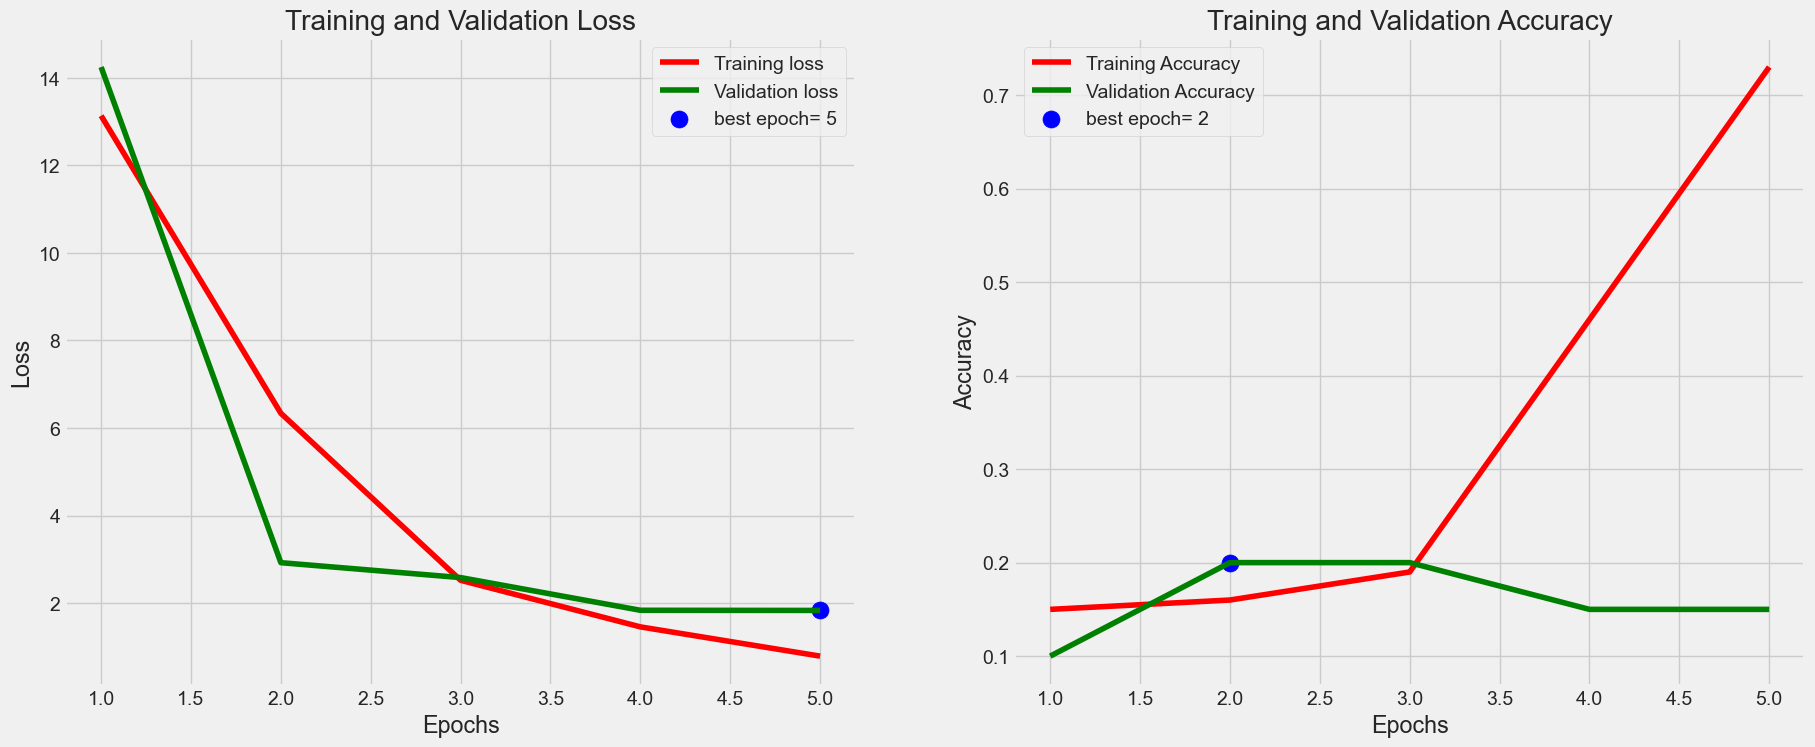

50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 452ms/step - accuracy: 0.9971 - loss: 0.0078


accuracy on the test set is 99.76 %


In [85]:
tr_plot(history,0)
save_dir=r'./'
subject='fruits'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)

50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 506ms/step


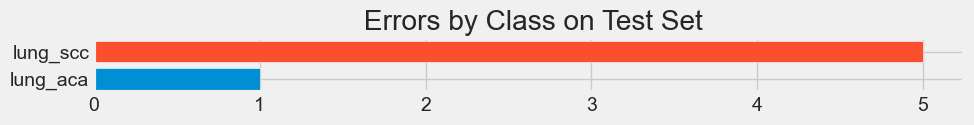

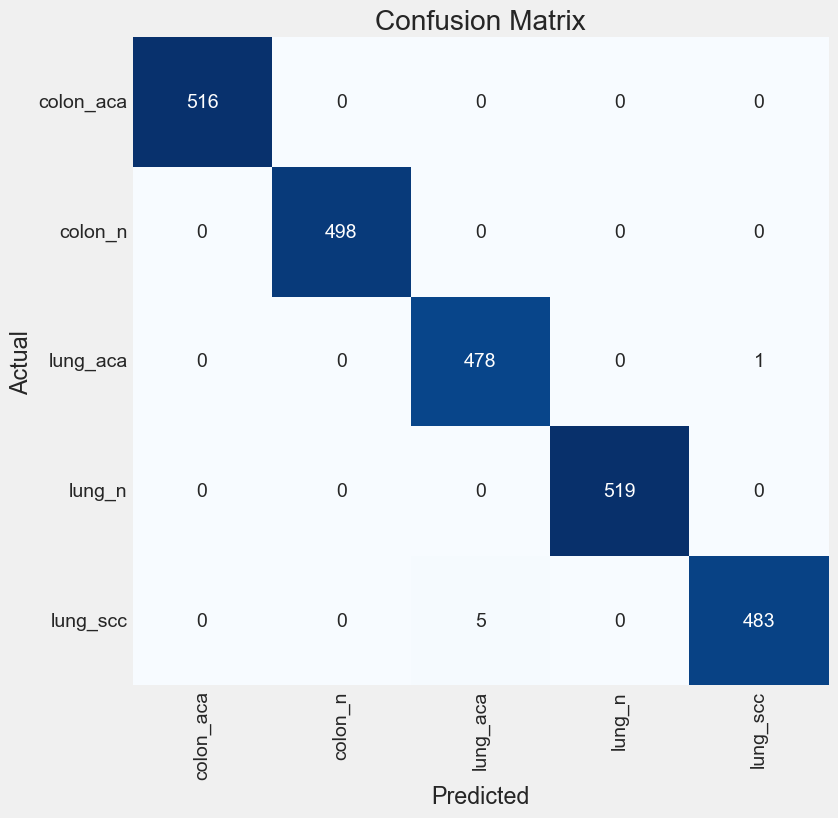

Classification Report:
----------------------
               precision    recall  f1-score   support

   colon_aca       1.00      1.00      1.00       516
     colon_n       1.00      1.00      1.00       498
    lung_aca       0.99      1.00      0.99       479
      lung_n       1.00      1.00      1.00       519
    lung_scc       1.00      0.99      0.99       488

    accuracy                           1.00      2500
   macro avg       1.00      1.00      1.00      2500
weighted avg       1.00      1.00      1.00      2500



In [87]:
print_code=0
preds=model.predict(test_gen) 
print_info( test_gen, preds, print_code, save_dir, subject ) 

In [103]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

image_path = '/Users/linhtuanpham/Downloads/lungscc.jpg'

img = load_img(image_path, target_size=(224, 224)) 
img_array = img_to_array(img)  
img_array = np.expand_dims(img_array, axis=0)  
img_array = img_array / 255.0  

predictions = model.predict(img_array)

classes = ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']
print(f"Dự đoán: {classes[predicted_class[0]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Dự đoán: lung_scc


In [135]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
image_set = '/Users/linhtuanpham/Downloads/lung_colon_image_set2'
SIZE_X = SIZE_Y = 224

datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split = 0.2)

train_set = datagen.flow_from_directory(image_set,
                                       class_mode = "categorical",
                                       target_size = (SIZE_X,SIZE_Y),
                                       color_mode="rgb",
                                       batch_size = 128, 
                                       shuffle = False,
                                       subset='training',
                                       seed = 42)

validate_set = datagen.flow_from_directory(image_set,
                                       class_mode = "categorical",
                                       target_size = (SIZE_X, SIZE_Y),
                                       color_mode="rgb",
                                       batch_size = 128, 
                                       shuffle = False,
                                       subset='validation',
                                       seed = 42)

Found 20000 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.


In [147]:
IMAGE_SIZE = [224, 224]
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [149]:
for layer in resnet.layers:
    layer.trainable = False
flatten = Flatten()(resnet.output)
dense = Dense(256, activation = 'relu')(flatten)
dense = Dense(128, activation = 'relu')(dense)
prediction = Dense(5, activation = 'softmax')(dense)
model = Model(inputs = resnet.input, outputs = prediction)
model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_16[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 49,311,621 (188.11 MB)

 Trainable params: 25,723,909 (98.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [151]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
history = model.fit(train_set, validation_data = (validate_set), epochs = 5, verbose = 1)

Epoch 1/5


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


157/157 ━━━━━━━━━━━━━━━━━━━━ 1089s 7s/step - accuracy: 0.4943 - loss: 23.0923 - val_accuracy: 0.9580 - val_loss: 0.1947
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 1090s 7s/step - accuracy: 0.9477 - loss: 0.2210 - val_accuracy: 0.9390 - val_loss: 0.2637
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 1089s 7s/step - accuracy: 0.9247 - loss: 0.6660 - val_accuracy: 0.9046 - val_loss: 0.6397
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 1086s 7s/step - accuracy: 0.9405 - loss: 0.4373 - val_accuracy: 0.9774 - val_loss: 0.0645
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 1095s 7s/step - accuracy: 0.9810 - loss: 0.0515 - val_accuracy: 0.9812 - val_loss: 0.0528


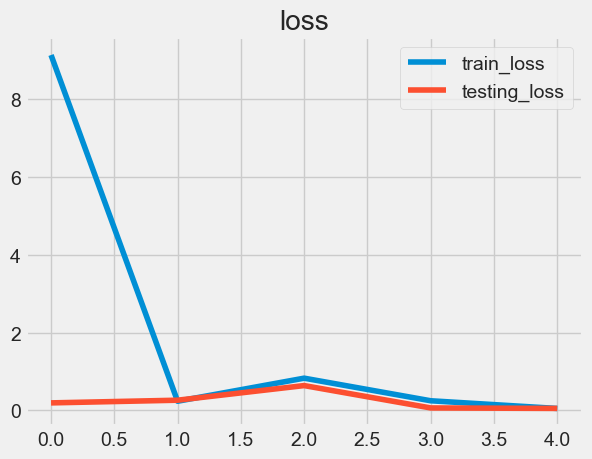

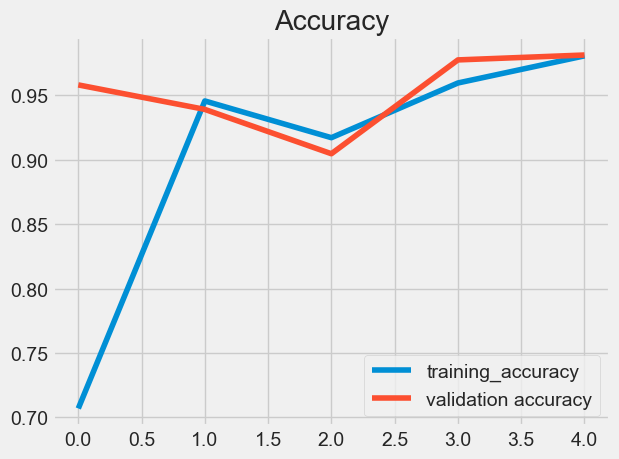

In [155]:
plt.plot(history.history['loss'],label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'testing_loss')
plt.title('loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'], label='training_accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [159]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
Y_pred = model.predict(validate_set)
y_pred = np.argmax(Y_pred ,axis =1)
print('Confusion Matrix')
confusion_matrix = confusion_matrix(validate_set.classes, y_pred)
print(confusion_matrix)
print('Classification Report')
target_names = ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']
print(classification_report(validate_set.classes, y_pred, target_names=target_names))

40/40 ━━━━━━━━━━━━━━━━━━━━ 210s 5s/step
Confusion Matrix
[[994   4   2   0   0]
 [  4 996   0   0   0]
 [  0   0 934   3  63]
 [  0   0   2 998   0]
 [  0   0  16   0 984]]
Classification Report
              precision    recall  f1-score   support

   colon_aca       1.00      0.99      0.99      1000
     colon_n       1.00      1.00      1.00      1000
    lung_aca       0.98      0.93      0.96      1000
      lung_n       1.00      1.00      1.00      1000
    lung_scc       0.94      0.98      0.96      1000

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000



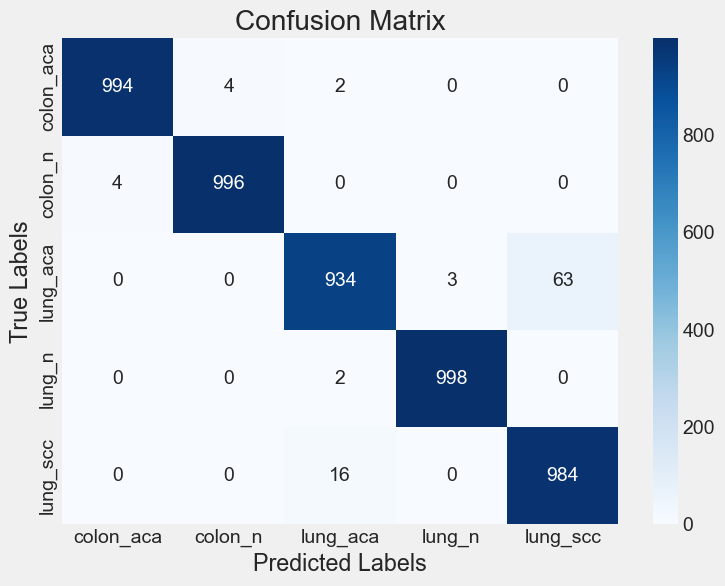

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Tạo confusion matrix
cm = confusion_matrix(validate_set.classes, y_pred)

# Vẽ heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [169]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

image_path = '/Users/linhtuanpham/Downloads/lungaca.jpg'

img = load_img(image_path, target_size=(224, 224)) 
img_array = img_to_array(img)  
img_array = np.expand_dims(img_array, axis=0)  
img_array = img_array / 255.0  

predictions = model.predict(img_array)

classes = ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']
print(f"Dự đoán: {classes[predicted_class[0]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Dự đoán: lung_scc


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

image_set = '/Users/linhtuanpham/Downloads/lung_colon_image_set2'

SIZE_X = SIZE_Y = 224
BATCH_SIZE = 64

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_set = datagen.flow_from_directory(
    image_set,
    target_size=(SIZE_X, SIZE_Y),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    seed=42
)

validate_set = datagen.flow_from_directory(
    image_set,
    target_size=(SIZE_X, SIZE_Y),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    seed=42
)

num_classes = len(train_set.class_indices)

model = Sequential([
    Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(SIZE_X, SIZE_Y, 3)),
    MaxPooling2D((3, 3), strides=(2, 2)),
    
    Conv2D(256, (5, 5), padding='same', activation='relu'),
    MaxPooling2D((3, 3), strides=(2, 2)),
    
    Conv2D(384, (3, 3), padding='same', activation='relu'),
    Conv2D(384, (3, 3), padding='same', activation='relu'),
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((3, 3), strides=(2, 2)),
    
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

history = model.fit(
    train_set,
    validation_data=validate_set,
    epochs=5,
    verbose=1
)

Found 20000 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 54, 54, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 26, 26, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 12, 12, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4096)           │    26,218,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │        20,485 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,767,493 (178.40 MB)

 Trainable params: 46,767,493 (178.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


313/313 ━━━━━━━━━━━━━━━━━━━━ 759s 2s/step - accuracy: 0.5874 - loss: 0.8593 - val_accuracy: 0.8410 - val_loss: 0.4198
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 764s 2s/step - accuracy: 0.8228 - loss: 0.4176 - val_accuracy: 0.8230 - val_loss: 0.4375
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 762s 2s/step - accuracy: 0.8601 - loss: 0.3415 - val_accuracy: 0.9174 - val_loss: 0.1978
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 768s 2s/step - accuracy: 0.9067 - loss: 0.2319 - val_accuracy: 0.9254 - val_loss: 0.1750
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 763s 2s/step - accuracy: 0.9469 - loss: 0.1385 - val_accuracy: 0.9458 - val_loss: 0.1517


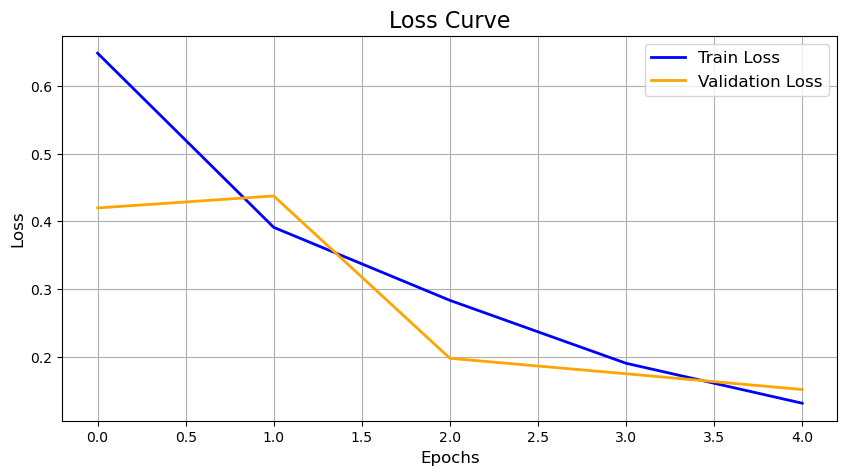

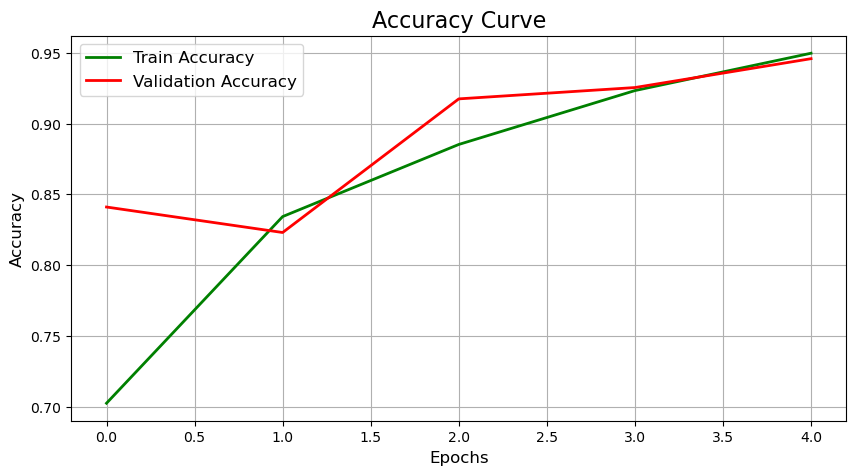

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
plt.title('Loss Curve', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', color='green', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', linewidth=2)
plt.title('Accuracy Curve', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

79/79 ━━━━━━━━━━━━━━━━━━━━ 48s 606ms/step


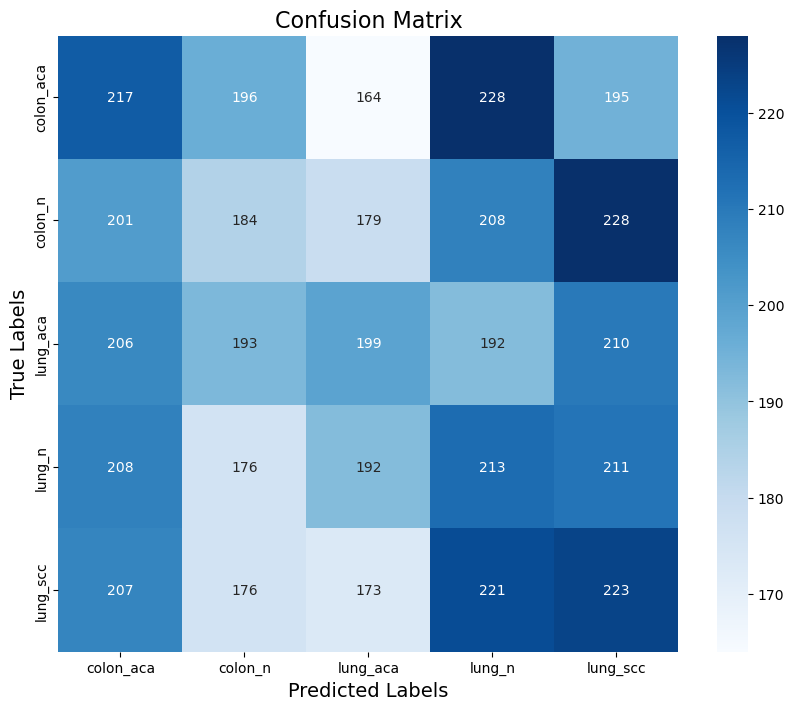

Classification Report
              precision    recall  f1-score   support

   colon_aca       0.21      0.22      0.21      1000
     colon_n       0.20      0.18      0.19      1000
    lung_aca       0.22      0.20      0.21      1000
      lung_n       0.20      0.21      0.21      1000
    lung_scc       0.21      0.22      0.22      1000

    accuracy                           0.21      5000
   macro avg       0.21      0.21      0.21      5000
weighted avg       0.21      0.21      0.21      5000



In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Dự đoán trên tập validation
Y_pred = model.predict(validate_set)
y_pred = np.argmax(Y_pred, axis=1)  # Chuyển đổi dự đoán thành nhãn (class index)

# Confusion Matrix
conf_matrix = confusion_matrix(validate_set.classes, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=validate_set.class_indices.keys(), yticklabels=validate_set.class_indices.keys())
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.show()

# Classification Report
print('Classification Report')
target_names = list(validate_set.class_indices.keys())
print(classification_report(validate_set.classes, y_pred, target_names=target_names))

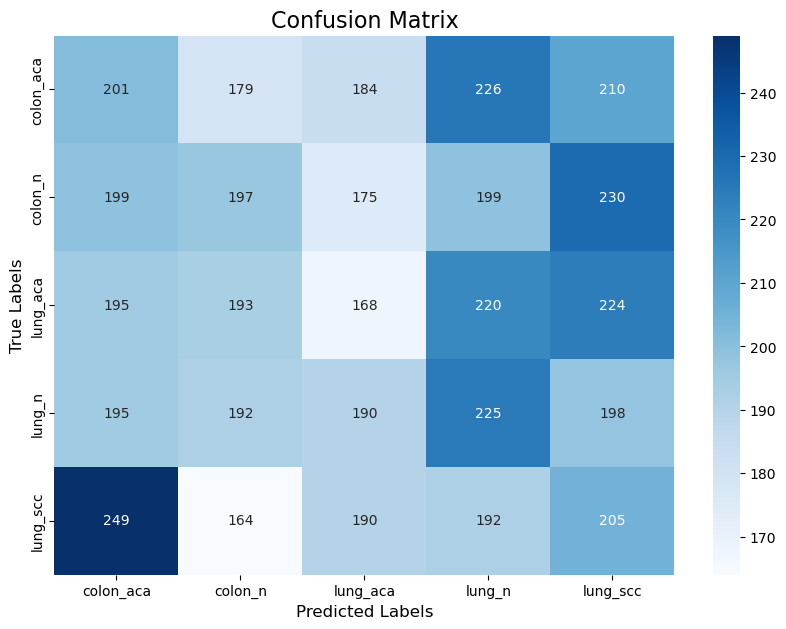

Classification Report:
              precision    recall  f1-score   support

   colon_aca       0.19      0.20      0.20      1000
     colon_n       0.21      0.20      0.20      1000
    lung_aca       0.19      0.17      0.18      1000
      lung_n       0.21      0.23      0.22      1000
    lung_scc       0.19      0.20      0.20      1000

    accuracy                           0.20      5000
   macro avg       0.20      0.20      0.20      5000
weighted avg       0.20      0.20      0.20      5000



In [20]:
# Tạo Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Lấy nhãn lớp từ validate_set
class_names = list(validate_set.class_indices.keys())

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.show()

# In Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Found 20000 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


313/313 ━━━━━━━━━━━━━━━━━━━━ 886s 3s/step - accuracy: 0.7502 - loss: 9.5017 - val_accuracy: 0.2000 - val_loss: 18.3934
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 906s 3s/step - accuracy: 0.9050 - loss: 5.8099 - val_accuracy: 0.5022 - val_loss: 5.6917
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 907s 3s/step - accuracy: 0.9361 - loss: 3.9081 - val_accuracy: 0.6258 - val_loss: 4.2028
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 906s 3s/step - accuracy: 0.9506 - loss: 2.7112 - val_accuracy: 0.7740 - val_loss: 2.5683
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 902s 3s/step - accuracy: 0.9587 - loss: 1.9275 - val_accuracy: 0.7648 - val_loss: 2.1481
79/79 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.7578 - loss: 2.1457
Validation Accuracy: 76.02%, Validation Loss: 2.1415


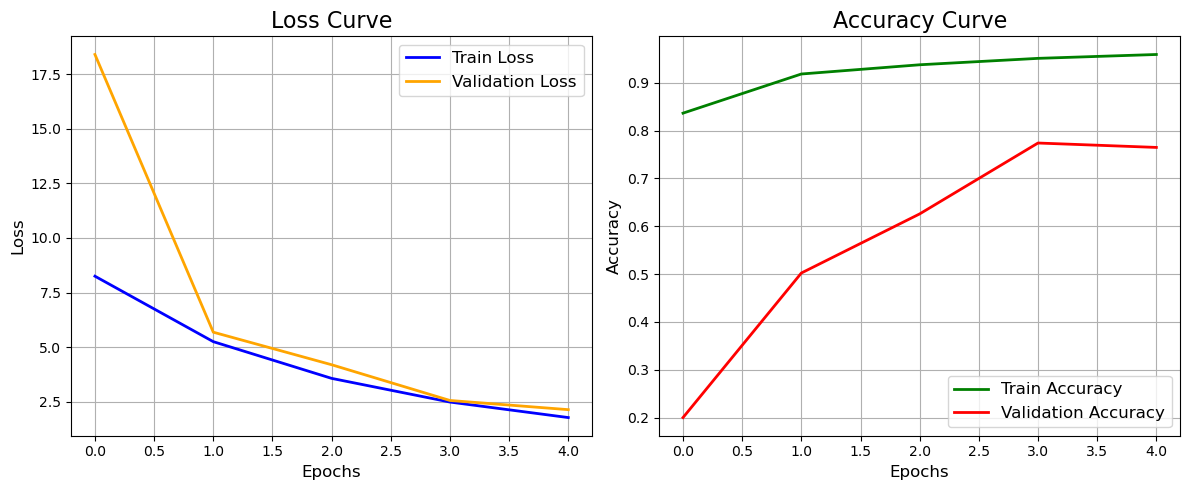

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

image_set = '/Users/linhtuanpham/Downloads/lung_colon_image_set2'
SIZE_X = SIZE_Y = 224

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_set = datagen.flow_from_directory(
    image_set,
    class_mode="categorical",
    target_size=(SIZE_X, SIZE_Y),
    batch_size=64,
    subset='training',
    seed=42
)

validate_set = datagen.flow_from_directory(
    image_set,
    class_mode="categorical",
    target_size=(SIZE_X, SIZE_Y),
    batch_size=64,
    subset='validation',
    seed=42
)

model = Sequential([
    Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=(SIZE_X, SIZE_Y, 3), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3), strides=2),

    Conv2D(256, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3), strides=2),

    Conv2D(384, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    Conv2D(384, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=(3, 3), strides=2),

    Flatten(),
    Dense(4096, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(4096, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_set,
    validation_data=validate_set,
    epochs=5,
    verbose=1
)

loss, accuracy = model.evaluate(validate_set, verbose=1)
print(f"Validation Accuracy: {accuracy * 100:.2f}%, Validation Loss: {loss:.4f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
plt.title('Loss Curve', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='green', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', linewidth=2)
plt.title('Accuracy Curve', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

79/79 ━━━━━━━━━━━━━━━━━━━━ 74s 935ms/step


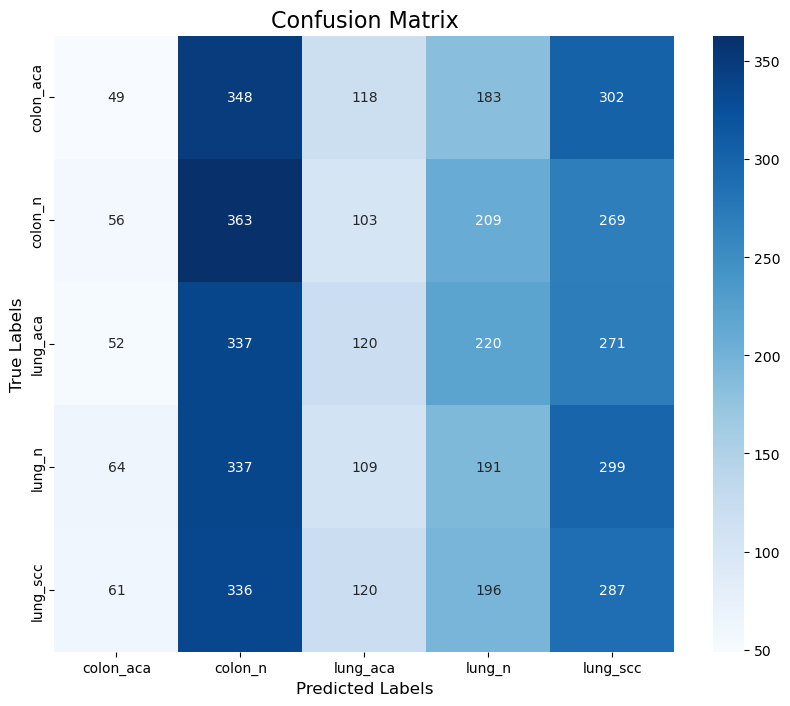

Classification Report:
              precision    recall  f1-score   support

   colon_aca       0.17      0.05      0.08      1000
     colon_n       0.21      0.36      0.27      1000
    lung_aca       0.21      0.12      0.15      1000
      lung_n       0.19      0.19      0.19      1000
    lung_scc       0.20      0.29      0.24      1000

    accuracy                           0.20      5000
   macro avg       0.20      0.20      0.18      5000
weighted avg       0.20      0.20      0.18      5000



In [28]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Dự đoán trên tập validation
Y_pred = model.predict(validate_set)
y_pred = np.argmax(Y_pred, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(validate_set.classes, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=validate_set.class_indices.keys(), yticklabels=validate_set.class_indices.keys())
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.show()

# Classification Report
target_names = list(validate_set.class_indices.keys())
print("Classification Report:")
print(classification_report(validate_set.classes, y_pred, target_names=target_names))

In [40]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

image_path = '/Users/linhtuanpham/Downloads/lungaca.jpg'

img = load_img(image_path, target_size=(224, 224)) 
img_array = img_to_array(img)  
img_array = np.expand_dims(img_array, axis=0)  
img_array = img_array / 255.0  

predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)

classes = ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']
print(f"Dự đoán: {classes[predicted_class[0]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Dự đoán: lung_n
